-Compute T(E,z_in, z_dep) by doing a delta function injection

-Why don't we ever keep track of how much DM is being depleted through annihilation/decay?

TODO:
- make contour plots
    - Pick a mass and make the plot corresponding to a vertical line going through the contour plot
    - Make a course contour plot
    - Once everything is debugged, make a very fine contour plot
- Clean up this Example12
    - migrate the main evolve function into a main.py that is conspicuous for the casual user
    - Change the inputs so that xe_init and T_init are computed for the user.
    - Make sure that the transfer functions are never seen (take them out of the input)
    - plots comparing back-reaction and no back-reaction
    - allow electron annihilation

This Notebook teaches the user to use the `main.evolve()` function.  Given a model of decaying or annihilating DM, `main.evolve()` will compute the free electron fraction as a function of redshift, $x_e(z) = n_e(z)/n_{HI}(z)$, and the baryon temperature as a function of redshift, $T_m(z)$.

# Full Transfer Functions

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


from astropy.io import fits

import numpy as np
import copy
import pickle

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tflist
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

from scipy.interpolate import interp1d

from tqdm import tqdm_notebook as tqdm

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

from darkhistory.low_energy.lowE_deposition import compute_fs
import main

# np.set_printoptions(threshold=np.nan)

In the standard temperature/ionization history calculation,
one solves the TLA assuming no DM energy injection. 

$$ \dot{T}_m = -2 H T_m + \Gamma_C \left(T_{CMB} - T_m \right), $$
$$ \dot{x}_e = - \mathcal{C} \left[ n_H x_e^2 \alpha_B - 4 (1 - x_e) \beta_B e^{-E_{21}/T_{CMB}} \right]. $$

The solution to these coupled ODEs provides $x_e$ and $T_m$ as functions of z, which are loaded below.

In [3]:
soln = pickle.load(open("../darkhistory/history/std_soln.p", "rb"))
xe_std  = interp1d(soln[0,:], soln[2,:])
T_m_std = interp1d(soln[0,:], soln[1,:])

To include the effect of DM energy injection, one adds to the TLA the following terms

$$ \dot{T}^\chi_m = \frac{2 f_\text{heat}(z)}{3 (1 + f_\text{He} + x_e(z)) n_H(z)} \left(\frac{dE}{dV \, dt} \right)^\text{inj}, $$
$$ \dot{x}^\chi_e = \left[\frac{f_\text{ion}(z)}{\mathcal{R} n_H(z)} + \frac{(1-\mathcal{C}) \; f_\text{exc}(z)}{0.75 \mathcal{R} n_H(z)} \right] \left(\frac{dE}{dV \, dt} \right)^\text{inj}. $$

Apparently one must know $f_{\{\text{heat, ion, exc}\}}(z)$ for all z to solve the TLA, which requires a knowledge of $x_e(z)$ and the histories of the DM decay/annihilation products.  Below we will either generate the $f_c$'s by using the standard history values ("without back-reaction"), or by including the effects of DM energy injection ("with back-reaction").

## Photon Transfer Functions

Transfer functions encode how particles (photons and electrons in our case) transfer energy as they evolve along with the universe.  For example, a high energy photon will lose energy through redshifting and scattering off of free electrons (what else am I missing???).  

Let $E_{in}^i$ be the energy of a single photon injected at redshift $z_{in}$. The photon produces $N^j$ photons at energies $E_{out}^j$ because of energy transfer processes that took place over $d(\ln(1+z))$ worth of cosmological time.  If we define $T^{ij} \equiv T(E_{in}^i, E_{out}^j)$, we have

$$ N_\gamma\left(E^j, (1+z_{in})e^{- d(\ln(1+z))} \right) = T^{ij} N_\gamma\left(E^i, 1+z_{in} \right), $$

where $N_\gamma(E, 1+z)$ represents the number of photons of energy E at redshift 1+z.  The transfer function allows us to evolve photon spectra $d(\ln(1+z))$ amount of time at a time.  We will set $d(\ln(1+z))$ = $0.002$ in our transfer functions, which has been shown to be small enough to converge.

We now load the transfer functions.

In [4]:
highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp = main.load_trans_funcs()

mDM = 1e11
phot_spec_init = spectools.rebin_N_arr(np.array([1]), 
                                      np.array([mDM]), 
                                      highengphot_tf_interp.eng)
phot_spec_init.switch_spec_type()

Loading transfer functions...
Loaded high energy photons...
Low energy photons...
Low energy electrons...
CMB losses.

Padding tflists with zeros...
high energy photons...
low energy photons...
low energy electrons.

Generating TransferFuncInterp objects for each tflist...
Done.



The above transfer functions end in `_interp` because only a finite number of them have been generated ($11 \times 494$ to be exact.  11 choices of ionization level, $x_e$, and 494 choices of input energy, $E_{in}$), which means we have to perform a 2D interpolation over different $x_e$ and $E_{in}$.

We now turn to the main function in DarkHistory: main.evolve().  It

In [12]:
%autoreload
phot_spec_init.rs = 3000
end_rs   = 2950
#mDM = 1e8
sigmav = 1e-26
tau = 1e24

def rate_func_swave_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)/(2*mDM)

def rate_func_swave_eng(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)

def rate_func_decay_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)/mDM

def rate_func_decay_eng(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)


def rate_func_swave_N_2(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav*1e-30)/(2*mDM)

def rate_func_swave_eng_2(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav*1e-30)

a = main.evolve(
    phot_spec_init*0, phot_spec_init,
    rate_func_decay_N, rate_func_decay_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    xe_init=xe_std(phot_spec_init.rs), Tm_init=phys.TCMB(phot_spec_init.rs), 
    coarsen_factor=1, std_soln=True
)

0.002
start to evolve
START LOOP

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999963 1.0000061761358293e-15 1.000006438199948e-15 1.0000070572768831e-15 1.0000059641221025e-15
Goods:  0.0005729437149842307
Split by photon and electron deposition!
f_phot:  [5.68345956e-04 5.97063975e-06 3.34595079e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.72947339e-19 5.72947472e-19 5.72946668e-19 5.72948136e-19
 5.72943715e-04]
fs:  [5.68345956e-04 5.97063975e-06 3.34595079e-05 5.72948136e-19
 5.72943715e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999963 1.0000064008310856e-15 1.0000066724294461e-15 1.0000073140291975e-15 1.0000061811040177e-15
Goods:  0.0034369621865359672
Split by photon and electron deposition!
f_phot:  [0.00868936 0.0002714  0.00065832 0.         0.        ]
f_elec:  [3.43698042e-18 3.43698110e-18 3.43697791e-18 3.43698687e-18
 3.43696219e-03]
fs:  [8.68935536e-03 2.71402736e-04 6.58315053e-04 3.43698687e-18
 3.43696219e-03]
Norm

../darkhistory/spec/spectrum.py:748: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999963 1.000006876647672e-15 1.0000071684358231e-15 1.0000078577300962e-15 1.000006640586753e-15
Goods:  0.010434933963594566
Split by photon and electron deposition!
f_phot:  [0.03579276 0.00100084 0.00225201 0.         0.        ]
f_elec:  [1.04349914e-17 1.04349935e-17 1.04349845e-17 1.04350130e-17
 1.04349340e-02]
fs:  [3.57927587e-02 1.00084096e-03 2.25200990e-03 1.04350130e-17
 1.04349340e-02]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999963 1.0000071284928116e-15 1.0000074309672276e-15 1.0000081455057575e-15 1.000006883786535e-15
Goods:  0.014380184165852508
Split by photon and electron deposition!
f_phot:  [0.05360717 0.00143339 0.0031626  0.         0.        ]
f_elec:  [1.43802658e-17 1.43802688e-17 1.43802564e-17 1.43802967e-17
 1.43801842e-02]
fs:  [5.36071747e-02 1.43339357e-03 3.16260177e-03 1.43802967e-17
 1.43801842e-02]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.99999999

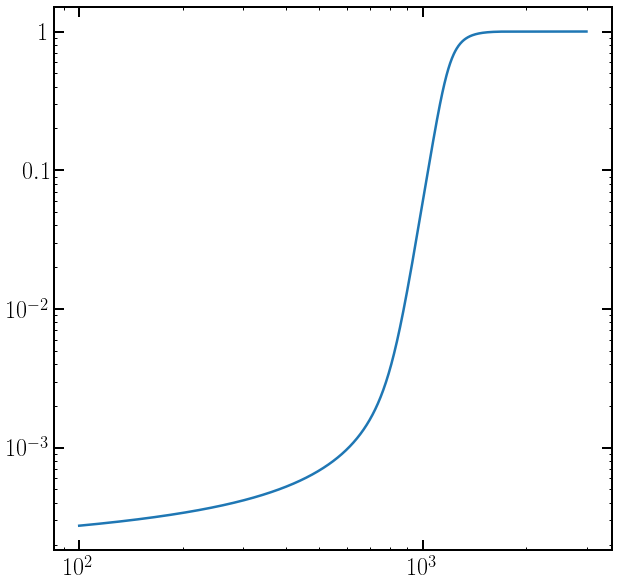

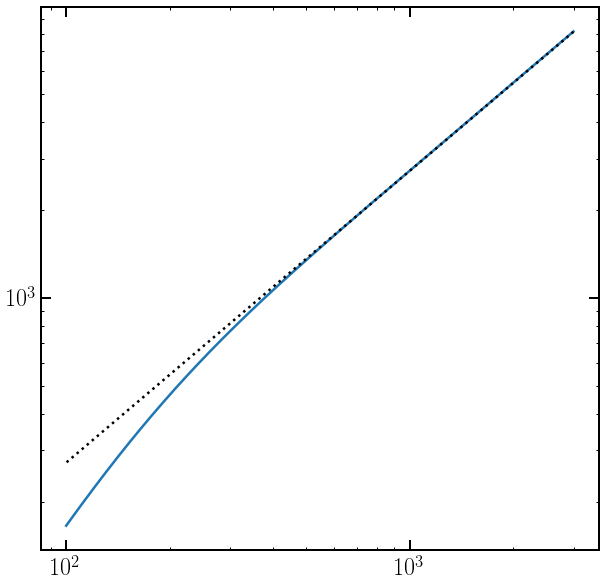

In [86]:
plt.figure()
# plt.plot(a[3].rs, a[0])
plt.plot(b[3].rs, b[0])
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')


plt.figure()
# plt.plot(a[3].rs, a[1]/phys.kB)
plt.plot(b[3].rs, b[1]/phys.kB)
plt.plot(b[3].rs, phys.TCMB(b[3].rs)/phys.kB, 'k:')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')


In [15]:
a[0]
a[3].rs[1:]

NameError: name 'a' is not defined

In [ ]:
a = 2
str(a)

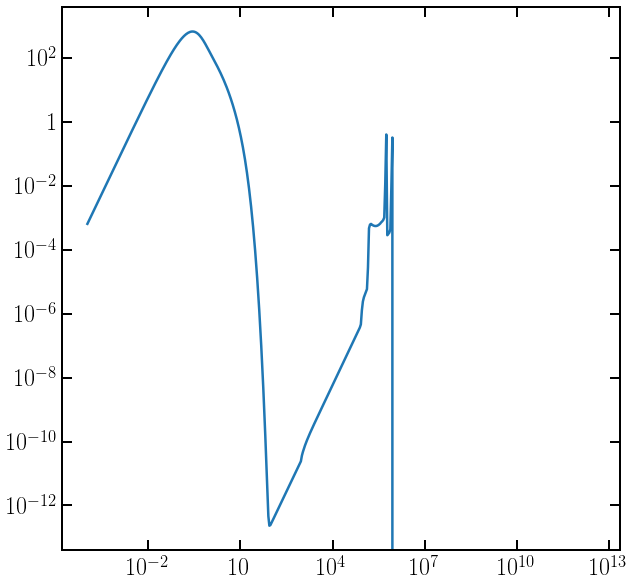

In [83]:
plt.figure()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

a = highengphot_tf_interp.get_tf(30, 2e-4)
a.plot(ax, ind = 300)